In [1]:
import pandas as pd
import random
import json
random.seed(8888)

In [2]:
movie_data = pd.read_csv('../data/movie_data.csv')
movie_data.dropna(subset=['year_released'], inplace=True)
drop_cols = ['image_url', 'imdb_id', 'imdb_link', 'tmdb_id', 'tmdb_link']
movie_data['year_released'] = movie_data['year_released'].astype('Int16')
movie_data['runtime'] = movie_data['runtime'].astype('Int16', errors='ignore')
movie_data.set_index('movie_id', inplace=True)

In [3]:
def format_movie_data(movie_data):
    """
    Converts a dictionary of movie data into a string format suitable for LLM fine-tuning.
    
    Args:
        movie_data (dict): A dictionary containing movie attributes such as title, language,
                           overview, and other metadata.
    
    Returns:
        str: A formatted string representation of the movie data.
    """
    # Define the order and the keys to include in the string
    keys_order = [
        "movie_title", "rating_val", "genres", "year_released", "popularity", "vote_average", "vote_count", "runtime", "production_countries", "original_language", "spoken_languages", "overview"
    ]
    
    # Building the string with key-value pairs
    formatted_string = " | ".join(f"{key}: {movie_data.get(key, 'N/A')}" for key in keys_order if key in movie_data)
    
    return formatted_string

In [4]:
import numpy as np

nan2list = lambda x: x if type(x) is str else '[]'

def format_movie_data_v2(movie_data): # , user_rating, user_review):
    release_yr = movie_data.get("year_released", None)
    title_fmt = movie_data.get("movie_title", "N/A") + (f" ({release_yr})" if release_yr else "")
    genre_fmt = ' and '.join([x.lower() for x in json.loads(nan2list(movie_data.get('genres', "[]")))])
    runtime = movie_data.get('runtime', None)
    if runtime is not None and not np.isnan(runtime):
        hours = int(runtime // 60)
        minutes = int(runtime % 60)
        runtime_fmt = f"{hours}h {minutes}m"
    else:
        runtime_fmt = "N/A"
    
    avg_rating = movie_data.get('vote_average')
    votes = movie_data.get('vote_count')
    if votes is not None and not np.isnan(votes) and votes > 0:
        votes = int(votes)
        avg_rating_fmt = f"{avg_rating:.2f} ({votes} vote(s))"
    else:
        avg_rating_fmt = "N/A"
    
    production_countries_fmt = ' and '.join(json.loads(nan2list(movie_data.get('production_countries', "[]")))) or 'N/A'
    languages_fmt = ' and '.join(json.loads(nan2list(movie_data.get('spoken_languages', "[]")))) or 'N/A'
    overview = movie_data.get("overview", "N/A")
    
    return f"""
Title: {title_fmt}
Genres: {genre_fmt}
Runtime: {runtime_fmt}
Average rating: {avg_rating_fmt}
Production countries: {production_countries_fmt}
Languages: {languages_fmt}
Overview: {overview}
""".strip()
        

In [5]:
print("Stringification V1")
print(format_movie_data(movie_data.iloc[100]))
print()
print("Stringification V2")
print(format_movie_data_v2(movie_data.iloc[100]))

Stringification V1
movie_title: Pelican Blood | genres: ["Drama"] | year_released: 2019 | popularity: 1.256 | vote_average: 6.3 | vote_count: 9.0 | runtime: 121.0 | production_countries: ["Bulgaria","Germany"] | original_language: de | spoken_languages: ["Magyar","Deutsch"] | overview: The horse trainer Wiebke adopts Raya from abroad, but soon she has to learn that the girl suffers from an attachment disorder and does not build an emotional connection to anybody around her. Raya constantly puts others in great danger, especially her older adoptive sister Nicolina. After a neurologist explains that Raya will have life-long troubles and does not feel any empathy, Wiebke has to decide whether she is willing to keep her and risk Nicolina’s well-being.

Stringification V2
Title: Pelican Blood (2019)
Genres: drama
Runtime: 2h 1m
Average rating: 6.30 (9 vote(s))
Production countries: Bulgaria and Germany
Languages: Magyar and Deutsch
Overview: The horse trainer Wiebke adopts Raya from abroad,

# user samples

In [6]:
ratings = pd.read_csv("../data/ratings_export.csv")
ratings.head()


,_id,movie_id,rating_val,user_id
0,5fc57c5d6758f6963451a07f,feast-2014,7,deathproof
1,5fc57c5d6758f6963451a063,loving-2016,7,deathproof
2,5fc57c5d6758f6963451a0ef,scripted-content,7,deathproof
3,5fc57c5d6758f6963451a060,the-future,4,deathproof
4,5fc57c5c6758f69634519398,mank,5,deathproof


## Fine-tuning GPT2 model

We will stream this dataset, because it takes a while to precompute it. We would rather like to see the language model's progress as it trains.


In [11]:
import transformers
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/gsk6me/huggingface_cache'

gpt2 = transformers.GPT2LMHeadModel.from_pretrained("openai-community/gpt2").to("cuda")
gpt2_tokenizer = transformers.GPT2Tokenizer.from_pretrained("openai-community/gpt2")

In [7]:
import torch
import torch.utils.data
import tqdm

class MovieRatingDataset(torch.utils.data.Dataset):
    def __init__(self, ratings, n_context_movies: int, tokenize=True):
        self.n_context_movies = n_context_movies
        
        user_counts = ratings.groupby('user_id').size().sort_values(ascending=False)
        user_ids = user_counts[user_counts > 10].index

        # Filter the ratings DataFrame to only include these users
        ratings = ratings[ratings['user_id'].isin(user_ids)]
        
        # Filter to movie ids that are in the movie index
        ratings = ratings[ratings['movie_id'].isin(movie_data.index)]
        
        # Filter to movie ids that are not nan
        ratings = ratings[~ratings['movie_id'].isna()]
        ratings = ratings[~ratings['rating_val'].isna()]
        
        # Generate rating spans
        rating_spans = []
        self.ratings_per_user = {}
        
        with tqdm.tqdm(user_ids, desc='Generating rating spans...') as pbar:
            grouped = ratings.groupby('user_id')
            for user_id in pbar:
                user_ratings = grouped.get_group(user_id)
                n_ratings = len(user_ratings)
                for start_i in range(0, max(1, n_ratings - n_context_movies)):
                    rating_spans.append((user_id, start_i, min(n_ratings, start_i + n_context_movies)))

                self.ratings_per_user[user_id] = user_ratings
                
        self.rating_spans = rating_spans
        
        self.tokenize = tokenize
        
    def __len__(self):
        return len(self.rating_spans)
    
    def __getitem__(self, index: int):
        (user_id, start_index, end_index) = self.rating_spans[index]
        
        ratings = self.ratings_per_user[user_id].iloc[start_index:end_index]
            
        # Returns raw string
        if not self.tokenize:
            result = ''
            for i, rating in ratings.iterrows():
                result += '---\n' + format_movie_data_v2(movie_data.loc[rating['movie_id']]) + f"\n---\nRating: {rating['rating_val']} / 10\n"
            
            return result
        
        out_of_10_tokens = gpt2_tokenizer(" / 10\n", return_tensors='pt')
        
        # Otherwise, returns the tokens, along with which ones correspond to ratings
        tokens = []
        total = 0
        rating_indexes = []
        rating_values = []
        for i, rating in ratings.iterrows():
            tokens.append(gpt2_tokenizer(
                '---\n' + format_movie_data_v2(movie_data.loc[rating['movie_id']]) + "\n---\nRating:",
                return_tensors='pt',
            ))
            total += len(tokens[-1].input_ids[0])
            
            rating_val = int(rating['rating_val'])
            assert 0 <= rating_val <= 10, "Invalid rating_val: " + str(rating_val)
            
            tokens.append(gpt2_tokenizer(f" {rating_val}", return_tensors='pt'))
            rating_indexes.append(total)
            rating_values.append(rating_val)
            total += 1
            
            tokens.append(out_of_10_tokens)
            total += 3 # len(out_of_10_tokens.input_ids)
            
        # Concatenate tokens
        tokens = {
            # batch size of 1 => [1, seqlen] gets concatenated along seqlen, while preserving batch dimension
            'input_ids': torch.cat([tok.input_ids for tok in tokens], dim=1)
        }
        ntok = len(tokens['input_ids'][0])
        # ignore the attention mask for now
        # tokens['attention_mask'] = torch.ones((1, ntok), dtype=torch.int64)
        
        # Truncate if necessary
        max_len = 1024
        if ntok >= max_len:
            tokens['input_ids'] = tokens['input_ids'][:, :max_len]
            # tokens['attention_mask'] = tokens['attention_mask'][:, :max_len]
            rating_indexes = [index for index in rating_indexes if index < max_len]
            rating_values = rating_values[:len(rating_indexes)]
            
        rating_indexes = torch.tensor(rating_indexes, dtype=torch.int64)
        
        return (tokens, rating_indexes, rating_values)


In [8]:
dataset = MovieRatingDataset(ratings, n_context_movies=10)

Generating rating spans...: 100%|██████████| 7366/7366 [00:04<00:00, 1524.03it/s]


## Verifying that we can acccurately select rating indexes

In [12]:
print("### This string should stop right before the rating is given")
tokens, rating_indexes, rating_values = dataset[0]
print(
    gpt2_tokenizer.decode(tokens['input_ids'][0][:rating_indexes[0]])
)

string = gpt2_tokenizer.decode(tokens['input_ids'][0])

print("### This is the maximum difference between the GPT2 tokenizer and our reconstruction")
print(
    max((gpt2_tokenizer(string, return_tensors='pt').input_ids[0] - tokens['input_ids'][0]).abs())
)

### This string should stop right before the rating is given
---
Title: Work (or To Whom Does the World Belong) (2019)
Genres: documentary
Runtime: 1h 5m
Average rating: N/A
Production countries: Spain and United Kingdom
Languages: English and Español
Overview: Children at recess are witnesses to the conflict between riot police and strikers. The neighborhood of a mining town is transformed into a battlefield for the last time. After the failure of the strike, calm returns to the streets and workers to work, with the certainty of knowing that the closure of the wells can no longer be stopped.
---
Rating:
### This is the maximum difference between the GPT2 tokenizer and our reconstruction
tensor(0)


# Second Approach: Reweighted

4/24/2024


In [38]:
import torch
import torch.nn.functional as F
import wandb
import tqdm

wandb.init(project='letterboxd-rl-rec')

device = 'cuda'
gpt2 = gpt2.to(device)
optimizer = torch.optim.Adam(gpt2.parameters(), lr=1e-4)

# creating a topologically valid loss function
tokens_0_to_10 = torch.tensor([gpt2_tokenizer(f' {i}', return_tensors='pt').input_ids[0][0] for i in range(11)], dtype=torch.int64, device='cuda')

targets = torch.zeros((11, 50257), device='cuda')
targets[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], tokens_0_to_10[:-1]] = 0.25
targets[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], tokens_0_to_10[1:]] = 0.25
targets[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], tokens_0_to_10] = 0.5
targets = targets / targets.sum(dim=-1, keepdim=True)
# ^ result: targets[0] = [0.66, 0.33, ...], targets[1] = [0.25, 0.5, 0.25, ...], targets[2] = [0, 0.25, 0.5, 0.25, ...]
# this spreads stuff out so nearby errors don't hurt as much


# the amount by which to weight tokens for predicting rating
# non-rating tokens will be weighted by 1 - weight_factor (as a regularization technique)
weight_factor = 1

order = torch.randperm(len(dataset))
with tqdm.tqdm(range(100000), desc='Training') as pbar:
    for step in pbar:
        index = order[step]
        (tokens, rating_indexes, rating_values) = dataset[index]
        input_ids = tokens['input_ids'].to(device)

        # Train to maximize the ll of this string.
        logits = gpt2(input_ids=input_ids).logits[0]
        # remove the last token prediction
        logprobs = torch.log_softmax(logits, dim=-1)[..., :-1, :]
        
        target_tokens = input_ids[0, 1:]
        target_probs = torch.zeros_like(logprobs)
        target_probs[torch.arange(len(logprobs)), target_tokens] = 1
        # print(rating_indexes, rating_values)
        # print(target_probs[rating_indexes - 1].shape, targets[rating_values].shape)
        target_probs[rating_indexes - 1] = targets[rating_values]
        
        logprobs_sel = (logprobs * target_probs).sum(dim=-1)
        
        # particularly select the logprobs of the tokens that are meant to predict ratings
        # non rating tokens
        loss = -(
            (logprobs_sel.sum() - logprobs_sel[rating_indexes - 1].sum()) * (1 - weight_factor) +
            logprobs_sel[rating_indexes - 1].sum() * weight_factor
        ) / ((len(logprobs_sel) - len(rating_indexes)) * (1 - weight_factor) + len(rating_indexes) * weight_factor)
        
        optimizer.zero_grad()
        loss.backward()
        wandb.log({"loss": loss.item()})
        optimizer.step()
        pbar.set_postfix(loss=loss.item())


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training:  80%|███████▉  | 79997/100000 [3:29:06<52:17,  6.38it/s, loss=1.9]    


KeyboardInterrupt: 

## First Approach: Non-Reweighted

4/15/2024


In [ ]:
import torch
import torch.nn.functional as F
import wandb
import tqdm

wandb.init(project='letterboxd-rl-rec')

optimizer = torch.optim.Adam(gpt2.parameters(), lr=1e-4)

order = torch.randperm(len(dataset))
with tqdm.tqdm(range(100000), desc='Training') as pbar:
    for step in pbar:
        index = order[step]
        string = dataset[index]

        # Train to maximize the ll of this string.
        tokenization = gpt2_tokenizer(string, return_tensors='pt', truncation=True)['input_ids'].cuda()
        logits = gpt2(input_ids=tokenization).logits
        logprobs = torch.log_softmax(logits[:, :-1], dim=-1)
        logprobs_sel = logprobs[0, torch.arange(tokenization.shape[-1] - 1), tokenization[0, 1:]]
        loss = -logprobs_sel.mean()
        optimizer.zero_grad()
        loss.backward()
        wandb.log({"loss": loss.item()})
        optimizer.step()
        pbar.set_postfix(loss=loss.item())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: myfatemi. Use `wandb login --relogin` to force relogin


Training:  18%|█▊        | 18194/100000 [41:41<3:07:07,  7.29it/s, loss=0.868] 

In [39]:
torch.save(optimizer, "optim_with_weighting.pt")
torch.save(gpt2, "model_with_weighting.pt")

In [40]:
tokenization = gpt2_tokenizer("---", return_tensors='pt', truncation=True).to('cuda')
results = gpt2.generate(**tokenization, max_new_tokens=500, temperature=1, repetition_penalty=1.25)
print(gpt2_tokenizer.decode(results[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--- 7 6 8 9 5 4 3 2 1 10 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7

In [30]:
print(dataset[order[-1]])

---
Title: To Make a Killing (1988)
Genres: horror
Runtime: 1h 28m
Average rating: 7.00 (2 vote(s))
Production countries: Australia
Languages: English
Overview: Damon Kennedy (Tamblyn Lord, The River Kings) is an impressionable young man ready to begin university life. On the other side of the tracks live Terry (Craig Pearce, co-author of Strictly Ballroom), Felix (John Godden) and Benny (Kelly Dingwall) — who get their kicks out of robbing houses and chasing girls. But they're broke and all out of cash.  During a routine burglary the gang discover an innocent Damon. Brushing off the intrusion and pretending they are looking for some mates, the gang flee the scene but bored Damon follows them and joins their group for the day, hoping to find some fun.When the gang picks up two girls, things become unhinged as a drunk Damon brags about some of his family's many affluent friends. Forced to take them to one of his cash-rich contacts, Damon's nightmare has only just begun. As Terry discove

In [41]:
string = """
---
Title: To Make a Killing (1988)
Genres: horror
Runtime: 1h 28m
Average rating: 7.00 (2 vote(s))
Production countries: Australia
Languages: English
Overview: Damon Kennedy (Tamblyn Lord, The River Kings) is an impressionable young man ready to begin university life. On the other side of the tracks live Terry (Craig Pearce, co-author of Strictly Ballroom), Felix (John Godden) and Benny (Kelly Dingwall) — who get their kicks out of robbing houses and chasing girls. But they're broke and all out of cash.  During a routine burglary the gang discover an innocent Damon. Brushing off the intrusion and pretending they are looking for some mates, the gang flee the scene but bored Damon follows them and joins their group for the day, hoping to find some fun.When the gang picks up two girls, things become unhinged as a drunk Damon brags about some of his family's many affluent friends. Forced to take them to one of his cash-rich contacts, Damon's nightmare has only just begun. As Terry discovers that the wealthy don't always carry cash, what starts as a burglary soon turns into a killing spree.
---
Rating: 5 / 10
---
Title: The Return of Captain Invincible (1983)
Genres: fantasy and action and comedy and science fiction
Runtime: 1h 36m
Average rating: 6.70 (13 vote(s))
Production countries: Australia
Languages: English
Overview: In WWII, Captain Invincible used his superpowers against the Nazis and was hailed as a hero. But when he was accused of treason, he retired to Australia in disgrace. Cut to the present, when a US super secret super weapon is stolen and he's asked to come back to the States in order to help stop evil and restore his sterling reputation. Unfortunately, Captain Invincible is a drunk now...
---
Rating: 4 / 10
---
Title: Found Footage 3D (2016)
Genres: horror
Runtime: 1h 41m
Average rating: 5.30 (64 vote(s))
Production countries: United States of America
Languages: English
Overview: A group of filmmakers sets out to make the first 3D found footage horror movie, but find themselves IN the first 3D found footage horror movie when the evil entity from their film escapes into their behind-the-scenes footage.
---
Rating:
""".strip()

tokenization = gpt2_tokenizer(string, return_tensors='pt', truncation=True).to('cuda')
results = gpt2.generate(**tokenization, max_new_tokens=10, temperature=1)
print(gpt2_tokenizer.decode(results[0]))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---
Title: To Make a Killing (1988)
Genres: horror
Runtime: 1h 28m
Average rating: 7.00 (2 vote(s))
Production countries: Australia
Languages: English
Overview: Damon Kennedy (Tamblyn Lord, The River Kings) is an impressionable young man ready to begin university life. On the other side of the tracks live Terry (Craig Pearce, co-author of Strictly Ballroom), Felix (John Godden) and Benny (Kelly Dingwall) — who get their kicks out of robbing houses and chasing girls. But they're broke and all out of cash.  During a routine burglary the gang discover an innocent Damon. Brushing off the intrusion and pretending they are looking for some mates, the gang flee the scene but bored Damon follows them and joins their group for the day, hoping to find some fun.When the gang picks up two girls, things become unhinged as a drunk Damon brags about some of his family's many affluent friends. Forced to take them to one of his cash-rich contacts, Damon's nightmare has only just begun. As Terry discove

## Evaluation

Given this trained model, let's see if the model is spending most of its "compute" on memorizing movie descriptions, or if it is spending most of it on learning the ratings!


In [40]:
gpt2 = torch.load("model.pt")

In [42]:
# 10 = max rating sequence length
results_by_context_length = {i: ([], []) for i in range(10)}

with tqdm.tqdm(range(100000, 101000), desc='Evaluating') as pbar:
    for i in pbar:
        user_id, start, end = dataset.rating_spans[order[i]]

        rating_sequence = dataset.ratings_per_user[user_id].iloc[start:end]

        for ctx_len in range(len(rating_sequence)):
            visible_ratings = rating_sequence.iloc[:ctx_len]
            string = ''
            for i, rating in visible_ratings.iterrows():
                mv = movie_data.loc[rating['movie_id']]
                formatted = format_movie_data_v2(mv)
                string += f"---\n{formatted}\n---\nRating: {int(rating['rating_val'])} / 10\n"

            test_rating = rating_sequence.iloc[ctx_len]
            mv = movie_data.loc[test_rating['movie_id']]
            formatted = format_movie_data_v2(mv)
            string += f"---\n{formatted}\n---\nRating:"

            tokenization = gpt2_tokenizer(string, return_tensors='pt', truncation=True).to('cuda')
            if len(tokenization.input_ids[0]) > 1022:
                continue

            with torch.no_grad():
                out = gpt2.generate(**tokenization, max_new_tokens=1, do_sample=False, pad_token_id=gpt2_tokenizer.eos_token_id)
            out = gpt2_tokenizer.decode(out[0])
            try:
                pred_rating = int(out.split()[-1])
            except:
                print(out)
            true_rating = int(test_rating['rating_val'])

            results_by_context_length[ctx_len][0].append(pred_rating)
            results_by_context_length[ctx_len][1].append(true_rating)


Evaluating: 100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]


In [66]:
# torch.save(results_by_context_length, "results_unweighted.pt")

results_by_context_length_weighted = torch.load("results_weighted.pt")
results_by_context_length_unweighted = torch.load("results_unweighted.pt")


In [70]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 128

def ctx_len_scatterplot(results_by_context_length):
    precision_history = []
    recall_history = []
    r2_history = []
    reward_history = []

    for i in range(10):
        pred, true = results_by_context_length[i]

        # Calculate "accuracy"
        pred = np.array(pred)
        true = np.array(true)

        # Try stratifying across true rating
        index_buckets = []
        for bucket in range(1, 11):
            indexes = np.where(true == bucket)[0]
            index_buckets.append(indexes[:100])
        indexes = np.concatenate(index_buckets)
        true = true[indexes]
        pred = pred[indexes]

        # create linear fit
        m, b = np.polyfit(true, pred, 1)

        plt.subplot(2, 5, i + 1)
        plt.scatter(true, pred, alpha=1/np.sqrt(len(pred)))
        min_true = min(true)
        max_true = max(true)
        plt.title(f"Context length {i}")
        plt.plot([min_true, max_true], [min_true * m + b, max_true * m + b], c='r')
        plt.xlabel("True rating")
        plt.ylabel("Predicted rating")
        plt.axis('equal')
        plt.xlim(0, 11)
        plt.ylim(0, 11)
        plt.xticks([0, 2, 4, 6, 8, 10])
        plt.yticks([0, 2, 4, 6, 8, 10])

        plt.scatter([1, 10], [1, 10], alpha=0)

        # calculate metrics
        linear_pred = true * m + b
        r2 = 1 - (((true - linear_pred) ** 2).sum() / ((true - true.mean()) ** 2).sum())

        acc = ((pred >= 7) == (true >= 7)).mean()
        tp = (pred >= 7) & (true >= 7)
        tn = (pred < 7) & (true < 7)
        fp = (pred >= 7) & (true < 7)
        fn = (pred < 7) & (true >= 7)
        precision = tp.sum()/(tp.sum()+fp.sum())
        recall = tp.sum()/(tp.sum()+fn.sum())
        # print(f"precision: {precision:.3f}, recall: {recall:.3f}, R^2: {r2:.3f}")

        precision_history.append(precision)
        recall_history.append(recall)
        r2_history.append(r2)
        reward_history.append(acc)

    plt.tight_layout()
    plt.show()
    
    return (precision_history, recall_history, r2_history, reward_history)


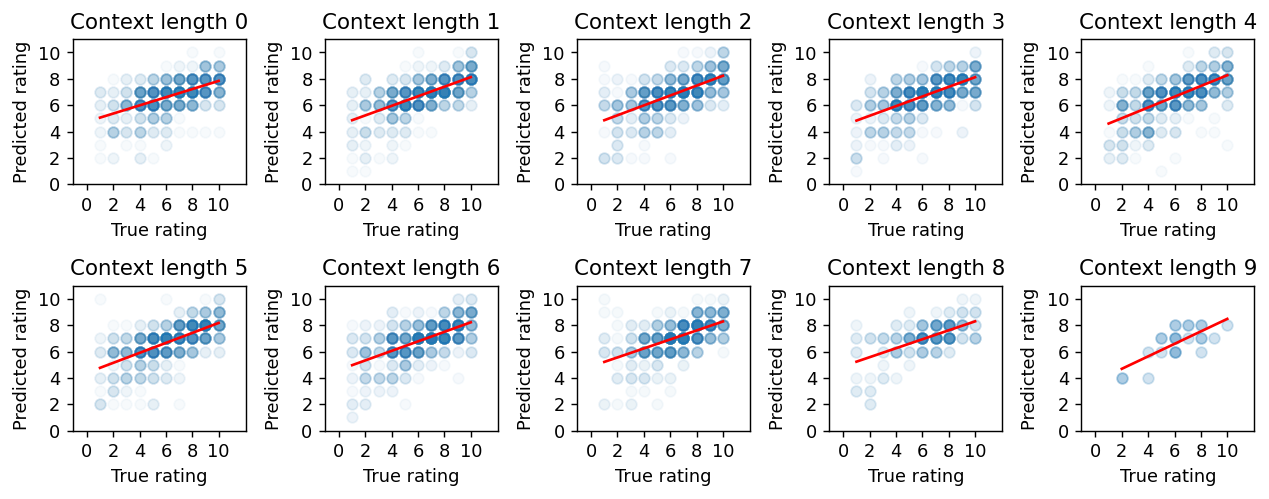

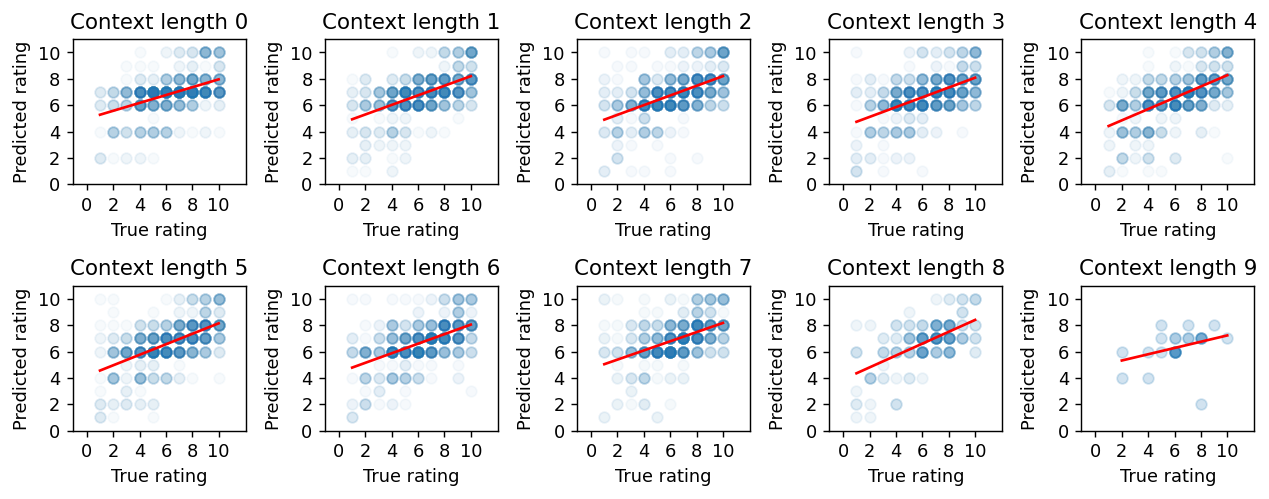

In [71]:
hist_weighted = ctx_len_scatterplot(results_by_context_length_weighted)
hist_unweighted = ctx_len_scatterplot(results_by_context_length_unweighted)

[0.7087378640776699, 0.7411444141689373, 0.719718309859155, 0.7224546722454672, 0.7330567081604425, 0.7334235453315291, 0.7237410071942446, 0.7041522491349481, 0.6544502617801047, 0.68]
[0.6532593619972261, 0.6907356948228883, 0.7098591549295775, 0.694560669456067, 0.7247579529737206, 0.7239512855209743, 0.7381294964028777, 0.7352941176470589, 0.7068062827225131, 0.8]


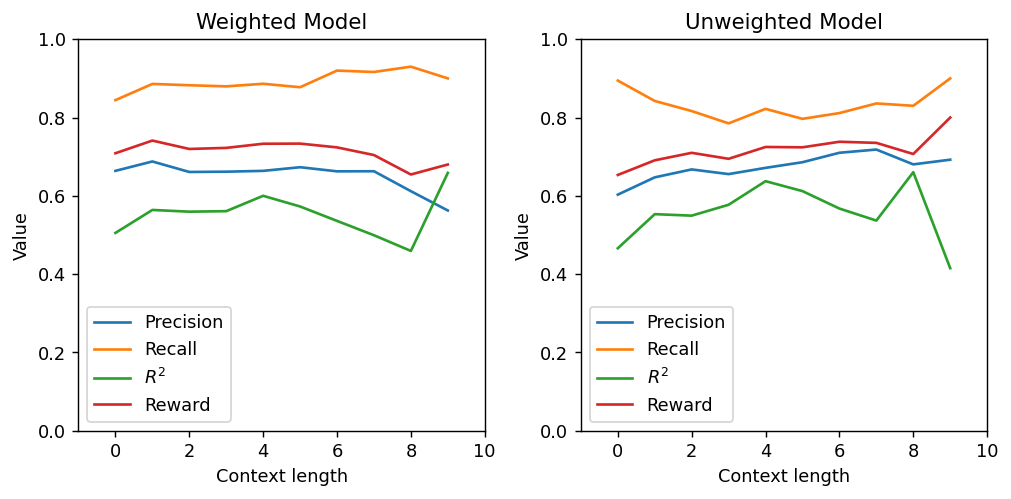

In [73]:
def plot_pr(hists):
    precision_history, recall_history, r2_history, reward_history = hists
    print(reward_history)
    plt.plot(precision_history, label='Precision')
    plt.plot(recall_history, label='Recall')
    plt.plot(r2_history, label='$R^2$')
    plt.plot(reward_history, label='Reward')
    plt.xlim(-1, 10)
    plt.xticks([0, 2, 4, 6, 8, 10])
    plt.ylim(0, 1)
    plt.xlabel("Context length")
    plt.ylabel("Value")
    plt.legend()

plt.rcParams['figure.figsize'] = (8, 4)
plt.subplot(1, 2, 1)

plt.title("Weighted Model")
plot_pr(hist_weighted)

plt.subplot(1, 2, 2)

plt.title("Unweighted Model")
plot_pr(hist_unweighted)

plt.tight_layout()

plt.show()

precision: 0.75, recall: 0.75
precision: 0.71, recall: 0.71
precision: 0.77, recall: 0.77
precision: 0.74, recall: 0.74
precision: 0.7, recall: 0.7
precision: 0.75, recall: 0.75
precision: 0.7368421052631579, recall: 0.7368421052631579
precision: 0.7090909090909091, recall: 0.7090909090909091
precision: 0.7727272727272727, recall: 0.7727272727272727
precision: 1.0, recall: 1.0


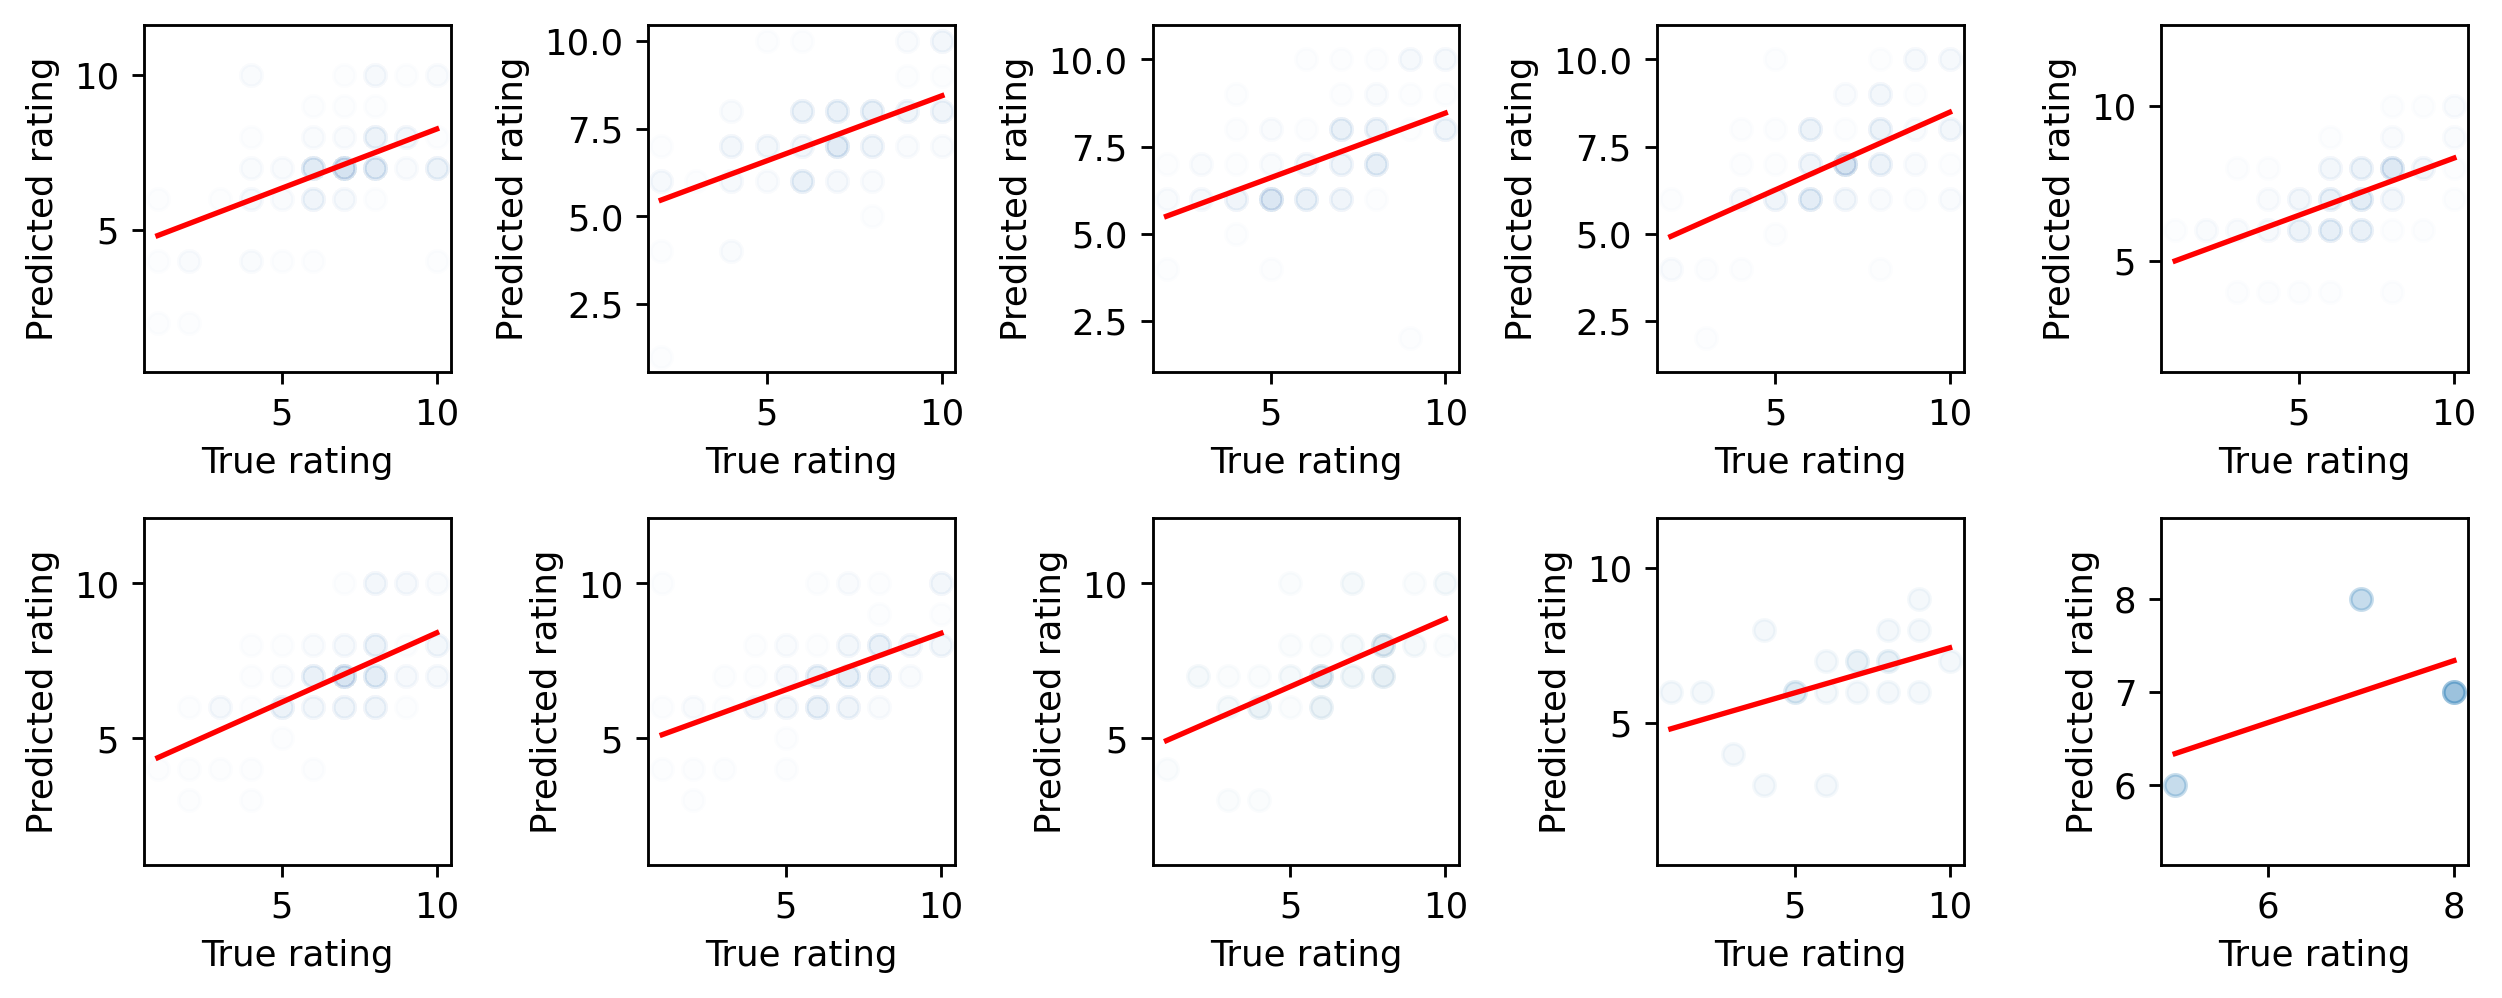

In [97]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 256
for i in range(10):
    pred, true = results_by_context_length[i]
    # create linear fit
    m,b = np.polyfit(true, pred, 1)
    plt.subplot(2, 5, i + 1)
    plt.scatter(true, pred, alpha=1/len(pred))
    min_true = min(true)
    max_true = max(true)
    plt.plot([min_true, max_true], [min_true * m + b, max_true * m + b], c='r')
    plt.xlabel("True rating")
    plt.ylabel("Predicted rating")
    plt.axis('equal')
    
    # Calculate "accuracy"
    pred = np.array(pred)
    true = np.array(true)
    tp = (pred >= 7) == (true >= 7)
    tn = (pred < 7) == (true < 7)
    fp = (pred >= 7) == (true < 7)
    fn = (pred < 7) == (true >= 7)
    precision = tp.sum()/(tp.sum()+fp.sum())
    recall = tp.sum()/(tp.sum()+fn.sum())
    print(f"precision: {precision}, recall: {recall}")

plt.tight_layout()
plt.show()

## Second Approach: Vectorized

In [ ]:
import torch
import torch.nn.functional as F
import wandb
import tqdm

# wandb.init(project='letterboxd-rl-rec')

optimizer = torch.optim.Adam(gpt2.parameters(), lr=1e-4)

order = torch.randperm(len(dataset))
with tqdm.tqdm(range(100000), desc='Training') as pbar:
    for step in pbar:
        index = order[step]
        string = dataset[index]

        # Train to maximize the ll of this string.
        tokens = gpt2_tokenizer(string, return_tensors='pt', truncation=True, padding='longest').to('cuda')
        logits = gpt2(**tokens).logits
        logprobs = torch.log_softmax(logits, dim=-1)
        
        for i, token in enumerate(tokens):
            logprobs_item = logprobs[i, :-1]
            logprobs_item[torch.arange(
        
        logprobs_sel = logprobs[0, torch.arange(tokenization.shape[-1] - 1), tokenization[0, 1:]]
        loss = -logprobs_sel.mean()
        optimizer.zero_grad()
        loss.backward()
        wandb.log({"loss": loss.item()})
        optimizer.step()
        pbar.set_postfix(loss=loss.item())


In [ ]:
# construct some strings for each of these users
def construct_ratings_set():
    user_ids = []
    rating_strings = []

    for user_id in tqdm.tqdm(users_filtered, desc='Creating dataset...'):
        user_ratings = filtered_ratings[filtered_ratings['user_id'] == user_id]

        # construct strings from each of these users
        user_rating_strings = []
        for rating_id, (_id, movie_id, rating_val, _user_id) in user_ratings.iterrows():
            if movie_id not in movie_data.index:
                continue
            movie_data = movie_data.loc[movie_id]
            user_rating_strings.append(format_movie_data_v2(movie_data, rating_val, "N/A"))
        user_ids.append(user_id)
        rating_strings.append(user_rating_strings)


In [ ]:
all_user_ids = filtered_ratings['user_id'].unique() 
random.shuffle(all_user_ids)
train_cutoff = int(len(all_user_ids)*4/5)
train_movie_ids = all_user_ids[:train_cutoff]
test_movie_ids = all_user_ids[train_cutoff:]

In [ ]:
train_movie_ids[0]

In [37]:
training_samples = []
system_prompt = "A movie recommendation system which takes in a list of movies and outputs the title of the next movie to watch. Only output the title of the movie."
user_history = "I have watched the following movies:\n"

for user in train_movie_ids[:1]:
    rating_history = filtered_ratings[filtered_ratings['user_id'] == user]
    combined = rating_history.merge(movie_data, on='movie_id')
    combined['movie_string'] = combined.apply(format_movie_data, axis=1)

    # split data into groups of 11 where 10 are the user's history and the last is the next movie to watch
    for i in range(0, len(combined), 10):
        if i + 10 >= len(combined):
            break
        watch_history = user_history + "\n".join(combined['movie_string'][i:i+10])
        next_movie = combined['movie_title'][i+10]
        sample = {
            "messages": 
                [
                    {"role": "system", "content": f"{system_prompt}"}, 
                    {"role": "user", "content": f"{watch_history}"}, 
                    {"role": "assistant", "content": f"{next_movie}"}
                ]
        }
        training_samples.append(sample)

with open('training_samples.jsonl', 'w') as file:
    for sample in training_samples:
        json_line = json.dumps(sample)
        file.write(json_line + '\n')

In [ ]:
client = OpenAI()
job_id = ""
client.fine_tuning.jobs.retrieve(f"{job_id}")

In [ ]:
# client = OpenAI()
# completion = client.chat.completions.create(
#   model="ft:gpt-3.5-turbo:my-org:custom_suffix:id",
#   messages=[
#     {"role": "system", "content": "You are a helpful assistant."},
#     {"role": "user", "content": "Hello!"}
#   ]
# )
# print(completion.choices[0].message)